In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch.utils.data import DataLoader,TensorDataset
from plots.gifs import trajectory_gif
from plots.plots import get_feature_history, plt_train_error, plt_norm_state, plt_norm_control, plt_classifier, feature_plot, plt_dataset
from models.training import Trainer, robTrainer
from models.neural_odes import NeuralODE, robNeuralODE
from models.resnets import ResNet
import pickle
import sys
import matplotlib.pyplot as plt
import imageio

from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

#if training = False, models will be loaded from file


In [2]:
hidden_dim, data_dim = 2, 2
T, num_steps = 5.0, 10  #T is the end time, num_steps are the amount of discretization steps for the ODE solver
dt = T/num_steps
turnpike = False
bound = 0.
fp = False
cross_entropy = True
noise = 0.2


training = True #train new network or load saved one
num_epochs = 2 #number of optimization epochs for gradient decent

if turnpike:
    weight_decay = 0 if bound>0. else dt*0.01
else: 
    weight_decay = dt*0.01          #0.01 for fp, 0.1 else

In [3]:
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity='tanh', 
                    architecture='outside', T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)

optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3, weight_decay=weight_decay) #weight decay parameter modifies norm
trainer_anode = Trainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, 
                        turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = False)


anode_test = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity='tanh', 
                    architecture='outside', T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)

optimizer_anode_test = torch.optim.Adam(anode_test.parameters(), lr=1e-3, weight_decay=weight_decay) #weight decay parameter modifies norm
trainer_anode_test = Trainer(anode_test, optimizer_anode_test, device, cross_entropy=cross_entropy, 
                        turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = False)


In [4]:
#NOW I USE IMPLEMENTED ADJOINT
rob_node = NeuralODE(device, data_dim, hidden_dim, adjoint = True, augment_dim=0, non_linearity='tanh', 
                            architecture='outside', T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)


optimizer_rob_node = torch.optim.Adam(rob_node.parameters(), lr=1e-3, weight_decay=weight_decay) #weight decay parameter modifies norm
trainer_rob_node = robTrainer(rob_node, optimizer_rob_node, device, cross_entropy=cross_entropy, 
                        turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = False)

x = torch.tensor([1.,2.])
rob_node(x)

rob_node(x + torch.tensor([0.5,0.5]))
                    

(tensor([3.8884, 0.5821], grad_fn=<AddBackward0>),
 tensor([[ 3.0499, -0.0346],
         [ 2.9069,  0.2364],
         [ 2.7729,  0.5903],
         [ 2.7523,  0.9638],
         [ 2.4026,  1.1522],
         [ 2.3357,  1.1824],
         [ 2.5455,  0.9758],
         [ 2.7181,  0.6679],
         [ 3.2609,  0.6052],
         [ 3.8884,  0.5821]], grad_fn=<AddmmBackward>))

initializing self.adjoint_flow creates additional layers into rob_node. Does this effect the learning? Or can I just save/load only the important ones and it will be fine?

In [5]:
'''Train or load the models'''

#%%capture #this surpresses output
shuffle = False


#old source for data points
#with open('data.txt', 'rb') as fp:
 #   data_line, test = pickle.load(fp)



X, y = make_circles(3000, noise=noise, factor=0.15, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05)

X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_test = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_test = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
y_train = y_train.type(torch.int64) #dtype of original picle.load data

X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
y_test = y_test.type(torch.int64) #dtype of original picle.load data


data_line = TensorDataset(X_train,y_train) # create your datset
test = TensorDataset(X_test, y_test)

dataloader = DataLoader(data_line, batch_size=64, shuffle=shuffle)
dataloader_viz = DataLoader(data_line, batch_size=128, shuffle=shuffle)


if training:
    trainer_anode.train(dataloader, num_epochs)
    #trainer_anode_test.train(dataloader, num_epochs)

    trainer_rob_node.train(dataloader, num_epochs)

    torch.save(anode.state_dict(), 'anode.pth')
    torch.save(rob_node.state_dict(), 'rob_node.pth')
else:
    anode.load_state_dict(torch.load('anode.pth'))
    rob_node.load_state_dict(torch.load('rob_node.pth'))

/Users/Tobi/FAUbox/Python/borjan dynamical.systems/models/training.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softpred = m(y_pred)


ModuleAttributeError: 'NeuralODE' object has no attribute 'adj_traj_p1'

In [ ]:
print(rob_node)
# print(anode)

robNeuralODE(
  (f_dynamics): Dynamics(
    (non_linearity): Tanh()
    (fc2_time): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): Linear(in_features=2, out_features=2, bias=True)
      (2): Linear(in_features=2, out_features=2, bias=True)
      (3): Linear(in_features=2, out_features=2, bias=True)
      (4): Linear(in_features=2, out_features=2, bias=True)
      (5): Linear(in_features=2, out_features=2, bias=True)
      (6): Linear(in_features=2, out_features=2, bias=True)
      (7): Linear(in_features=2, out_features=2, bias=True)
      (8): Linear(in_features=2, out_features=2, bias=True)
      (9): Linear(in_features=2, out_features=2, bias=True)
    )
  )
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
  

normal


/Users/Tobi/FAUbox/Python/borjan dynamical.systems/plots/plots.py:382: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = m(pre_)


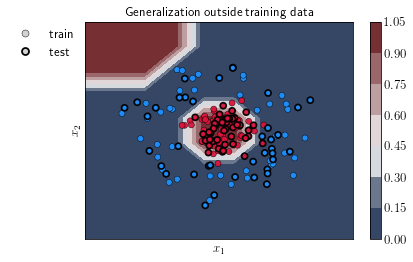

robust


/Users/Tobi/FAUbox/Python/borjan dynamical.systems/plots/plots.py:382: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = m(pre_)


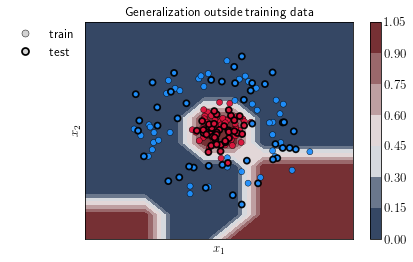

tensor([-0.0437,  9.1015])


In [ ]:
filename_base = '1traj'

filename_s = filename_base + '_s'
filename_r = filename_base + '_r'

print('normal')
plt_classifier(anode, data_line, test, num_steps=10, save_fig = '1generalization.png') 

print('robust')
plt_classifier(rob_node, data_line, test, num_steps=10, save_fig = '1rob_generalization.png') 


# plt.figure(1)
# plt.subplot(121)
# plt.imshow(imageio.imread('1generalization.png'))
# plt.title('standard')
# plt.axis('off')
# plt.subplot(122)
# plt.imshow(imageio.imread(filename_r + '29.png'))
# plt.title('augmented robustness')
# plt.axis('off')

inputs, targets = next(iter(dataloader_viz))
print(sum(inputs))



trajectory_gif(anode, inputs, targets, timesteps=num_steps, filename = filename_s +'.gif')
trajectory_gif(rob_node, inputs, targets, timesteps=num_steps, filename = filename_r + '.gif')
filename_base = '1traj'


# plt.figure(1)
# plt.subplot(121)
# plt.imshow(imageio.imread(filename_s + '29.png'))
# plt.title('standard')
# plt.axis('off')
# plt.subplot(122)
# plt.imshow(imageio.imread(filename_r + '29.png'))
# plt.title('augmented robustness')
# plt.axis('off')

# plt.savefig('1comparison_' + filename_base + '.png',
#                     format='png', dpi=300, bbox_inches='tight')

# from IPython.display import Image
# Image(filename='1comparison_1traj.png') 

In [ ]:
print(rob_node.state_dict)

print('anode')

for name, param in anode.named_parameters():
    if param.requires_grad:
        print(name, param.data)


print('\n','anode_test')


for name, param in anode_test.named_parameters():
    if param.requires_grad:
        print(name, param.data)

        
        
print('\n','rob_node')


for name, param in rob_node.named_parameters():
    if param.requires_grad:
        print(name, param.data)

<bound method Module.state_dict of robNeuralODE(
  (f_dynamics): Dynamics(
    (non_linearity): Tanh()
    (fc2_time): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): Linear(in_features=2, out_features=2, bias=True)
      (2): Linear(in_features=2, out_features=2, bias=True)
      (3): Linear(in_features=2, out_features=2, bias=True)
      (4): Linear(in_features=2, out_features=2, bias=True)
      (5): Linear(in_features=2, out_features=2, bias=True)
      (6): Linear(in_features=2, out_features=2, bias=True)
      (7): Linear(in_features=2, out_features=2, bias=True)
      (8): Linear(in_features=2, out_features=2, bias=True)
      (9): Linear(in_features=2, out_features=2, bias=True)
    )
  )
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_featur

In [ ]:
x =torch.tensor([[1,2],[3,4]])
print(x)
print(torch.mm(x,x+1))

tensor([[1, 2],
        [3, 4]])
tensor([[10, 13],
        [22, 29]])


In [ ]:
# w1_t = anode.state_dict.fc1_time[1].weight
wt = anode.flow.dynamics.fc2_time[0].weight
bt = anode.flow.dynamics.fc2_time[0].bias

x = torch.zeros(100,2)
x[0] = torch.tensor([1.,2.])
w = torch.tensor([[0.,-1.],[1.,0.]])
print('x', x[0])
print('inner',torch.matmul(w,x[0])+ x[0]) 
inner = torch.matmul(w,x[0])+ x[0]
inner = torch.diag_embed(inner)
print('embedd', torch.diag_embed(inner))
outer = torch.matmul(w.t(),inner)
print('outer',outer)
print('final', torch.matmul(outer,x[0]))
# print(torch.matmul(mat.t(),x[1]))

out = torch.matmul(x,w.t()) + x
out = torch.diag_embed(out)
out = torch.matmul(w.t(),out)
x = x[:,:,None]
out = torch.matmul(out,x)
# print(out)
print('x',x.size(),'out', out.size())
print(out.size())
print(out.flatten(start_dim=1).size())



x tensor([1., 2.])
inner tensor([-1.,  3.])
embedd tensor([[[-1.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  3.]]])
outer tensor([[0., 3.],
        [1., 0.]])
final tensor([6., 1.])
x torch.Size([100, 2, 1]) out torch.Size([100, 2, 1])
torch.Size([100, 2, 1])
torch.Size([100, 2])
